**Project 2: Implementing LSTMs and their variations. (Part 1)**

**Teammates: Juilee Rege (jrege3) and Katha Chanda (kchanda3)**

Due Date: 3rd May 2017

Long Short Term Memory (LSTM)

An LSTM network is an artificial neural network that contains LSTM units rather than other network units. LSTM units are able to remember values for long or short periods of time because they do not use any activation function within its recurring components. This means the gradient does not vanish when backpropagation is applied [1]. 

An LSTM can be used in many applications and the most popular ones are language detection and character or string predictions. In this application, an LSTM tries to emulate human behavior. When humans read text, they never read characters on their own as in they don't start thinking from scratch every second. Whatever they read and understand is always a connection or linked with what they have read before. This is the meaning of saying 'understand from context', wherein the meaning of a difficult word can be figured out by understanding the nature of its usage by reading the previous text.

In the same manner, for an LSTM to predict a character, it is trained on lots of text, the more the better as it is for any machine learning model. Then, to predict a single character, a series of characters occuring before it are passed to the model, which can be called the history. As an example to explain this working, imagine the following sentence:

**The color of the sky is b**

The model has to predict the next letter which should follow. By passing just a single or a few previous occuring characters, it will not be able to understand what comes next much like us humans. If we were given 'is b' and told to predict the next character, it would be literally impossible because the string given makes no sense on its own and anything can follow it. The more the history passed to the model, the better it will perform. In this case, if it is passed the complete sentence prior to the unknown letter, then it will be able to predict the next letter as 'l' much like if the entire string was given to humans, we would understand that the upcoming word has to be the color of the sky which is blue.

In this project, the aim is to train two LSTM models with English and French texts thus making them proficient in detecting these languages. After training, 100 test strings will be passed to each of these models and the language of the strings will be predicted. The aim is to make the models better and better to accurately predict what language the test string is written in.

In [97]:
import tensorflow as tf
import keras
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Merge
from keras.optimizers import RMSprop, SGD
from keras.utils.data_utils import get_file
import numpy as np
from sklearn.metrics import *
from sklearn import metrics
import matplotlib.pyplot as plt
import math
import random
import sys
import os

The next cell reads the text from the English and French files and displays how many characters each file contains.

In [98]:
X_eng = open("eng.txt").read().lower()
print('X_eng length:', len(X_eng))

X_frn = open("frn.txt").read().lower()
print('X_frn length:', len(X_frn))

X_eng length: 10746
X_frn length: 12009


The next cell splits the entire text into 80/20 learning and holdout subsets by taking the initial 80% of the file as learning and the remaining as testing. The reason we did not randomly divide was because in that case, the chosen characters would be random and hence the training set formed from them would not semantically make any sense. Thus, in the case of making our models predict sentences, it would end up predicting sentences which had no meaning and would be rubbish.

In [99]:
#### for english #####
numberE = int(0.80 * len(X_eng))
X_train_eng = X_eng[:numberE]
X_val_eng = X_eng[numberE:]
print ("English")
print ("training set contains ", len(X_train_eng), " characters")
print ("validation set contains ", len(X_val_eng), " characters")
print ("")
#### for french #####
numberF = int(0.80 * len(X_frn))
X_train_frn = X_frn[:numberF]
X_val_frn = X_frn[numberF:]
print ("French")
print ("training set contains ", len(X_train_frn), " characters")
print ("validation set contains ", len(X_val_frn), " characters")
print ("")

English
training set contains  8596  characters
validation set contains  2150  characters

French
training set contains  9607  characters
validation set contains  2402  characters



The following cell constructs the character set to be used by the models. Now, the French and English character set differs slightly. The French character set does not contain the characters 'k', 'w', 'z'. Thus, if the French model was trained on its own character set then it would not provide predictions for any English words in which these characters occur. Thus, a common character set was created combining both of them. It consists of 44 characters.

In [100]:
charsE = sorted(list(set(X_eng)))
charsF = sorted(list(set(X_frn)))
chars = set(charsE+charsF)
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 44


We have considered a history or max length of 40 characters to be given to the models to help it train. This is following the blog that was provided as a link in the homework pdf. [5] This means that we are giving the model, strings, of length 40 to learn on so that it can predict the next character with this history. The following cell does this action.

In [101]:
#### for english ####
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences_trainE = []
next_chars_trainE = []
for i in range(0, len(X_train_eng) - maxlen, step):
    sentences_trainE.append(X_train_eng[i: i + maxlen])
    next_chars_trainE.append(X_train_eng[i + maxlen])
print('nb sequences:', len(sentences_trainE))

maxlen = 40
step = 3
sentences_valE = []
next_chars_valE = []
for i in range(0, len(X_val_eng) - maxlen, step):
    sentences_valE.append(X_val_eng[i: i + maxlen])
    next_chars_valE.append(X_val_eng[i + maxlen])
print('nb sequences:', len(sentences_valE))

#### for french ####
maxlen = 40
step = 3
sentences_trainF = []
next_chars_trainF = []
for i in range(0, len(X_train_frn) - maxlen, step):
    sentences_trainF.append(X_train_frn[i: i + maxlen])
    next_chars_trainF.append(X_train_frn[i + maxlen])
print('nb sequences:', len(sentences_trainF))

maxlen = 40
step = 3
sentences_valF = []
next_chars_valF = []
for i in range(0, len(X_val_frn) - maxlen, step):
    sentences_valF.append(X_val_frn[i: i + maxlen])
    next_chars_valF.append(X_val_frn[i + maxlen])
print('nb sequences:', len(sentences_valF))

nb sequences: 2852
nb sequences: 704
nb sequences: 3189
nb sequences: 788


There is a need to vectorize the training strings that have been created because after all, the model will take in numerical input only and not letters or words. The following cell vectorizes the strings using the character-to-indices dictionary we created earlier.

In [102]:
#### for english ####
print('Vectorization...')
X_train_eng_vec = np.zeros((len(sentences_trainE), maxlen, len(chars)), dtype=np.bool)
y_train_eng_vec = np.zeros((len(sentences_trainE), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_trainE):
    for t, char in enumerate(sentence):
        X_train_eng_vec[i, t, char_indices[char]] = 1
    y_train_eng_vec[i, char_indices[next_chars_trainE[i]]] = 1

X_val_eng_vec = np.zeros((len(sentences_valE), maxlen, len(chars)), dtype=np.bool)
y_val_eng_vec = np.zeros((len(sentences_valE), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_valE):
    for t, char in enumerate(sentence):
        X_val_eng_vec[i, t, char_indices[char]] = 1
    y_val_eng_vec[i, char_indices[next_chars_valE[i]]] = 1

#### for french ####
print('Vectorization...')
X_train_frn_vec = np.zeros((len(sentences_trainF), maxlen, len(chars)), dtype=np.bool)
y_train_frn_vec = np.zeros((len(sentences_trainF), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_trainF):
    for t, char in enumerate(sentence):
        X_train_frn_vec[i, t, char_indices[char]] = 1
    y_train_frn_vec[i, char_indices[next_chars_trainF[i]]] = 1

X_val_frn_vec = np.zeros((len(sentences_valF), maxlen, len(chars)), dtype=np.bool)
y_val_frn_vec = np.zeros((len(sentences_valF), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_valF):
    for t, char in enumerate(sentence):
        X_val_frn_vec[i, t, char_indices[char]] = 1
    y_val_frn_vec[i, char_indices[next_chars_valF[i]]] = 1


Vectorization...
Vectorization...


We are creating an LSTM model using the keras Sequential() functionality. We added an LSTM layer to the model with 128 hidden units and an input layer capable of taking an input of shape 40 x 44. A dense layer and then an activation layer were also added with a softmax activation. We used RMSprop as an optimizer and categorical cross entropy as the loss function. This structure was similar in both models.

In [103]:
#### for english ####
print('Build model...')
modelE = Sequential()
modelE.add(LSTM(128, input_shape=(maxlen, len(chars))))
modelE.add(Dense(len(chars)))
modelE.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
modelE.compile(loss='categorical_crossentropy', optimizer=optimizer)

#### for french ####
print('Build model...')
modelF = Sequential()
modelF.add(LSTM(128, input_shape=(maxlen, len(chars))))
modelF.add(Dense(len(chars)))
modelF.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
modelF.compile(loss='categorical_crossentropy', optimizer=optimizer)


Build model...
Build model...


In [104]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def sample_for_prediction(preds, temperature=0.2):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    return preds #exp_preds

We created a validation tuple using the X and y validation vectors. This is going to be given as input to the training of the model so that we can view the validation loss as the model is training. Usually, the model is trained the best at the point at which the training loss keeps reducing and the validation loss has reached its minimum point. After this point, if the validation loss increases, it means the model is overfitting. 

In [105]:
X_val_tupleE = (X_val_eng_vec,y_val_eng_vec)
print (len(X_val_tupleE[0]))
X_val_tupleF = (X_val_frn_vec,y_val_frn_vec)
print (len(X_val_tupleF[0]))

704
788


We are training the model for 5 iterations using 5 epochs. We did a lot of trial and error to see in which case the model was performing its best. Since the dataset is reasonably small, these many steps were enough to provide good results. At the very start, we set it training for 200 iterations thinking it will train the model very well, and it gave good generated sentences. But when we wanted to predict the next letter based on test strings, it did not do so well because evidently the model had been overfit.

As can be seen, the English model ends with a training loss of 0.2223 and validation loss of 2.7825, with both the losses consistently decreasing. The generated sentences are not very great but it has learnt what constitutes an English word and while testing, performs really well.

The French model ends with a training loss of 0.2229 and validation loss of  2.8657. The generated sentences, although not very good, do contain french words.

In [143]:
#### for english ####
for iteration in range(0, 5):
    print()
    print('-' * 50)
    print('Iteration', iteration+1)
    modelE.fit(X_train_eng_vec, y_train_eng_vec, batch_size=128, epochs=5, validation_data=X_val_tupleE)

    start_index = random.randint(0, len(X_eng) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = X_eng[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(300):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = modelE.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

#### for french ####
for iteration in range(0, 5):
    print()
    print('-' * 50)
    print('Iteration', iteration+1)
    modelF.fit(X_train_frn_vec, y_train_frn_vec, batch_size=128, epochs=5, validation_data=X_val_tupleF)

    start_index = random.randint(0, len(X_frn) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = X_frn[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(300):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = modelF.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


--------------------------------------------------
Iteration 1
Train on 2852 samples, validate on 704 samples
Epoch 1/5
2852/2852 [==============================] - 12s - loss: 3.1006 - val_loss: 2.9612

In [111]:
modelE.save('English-5epochs-5iters.h5')
modelF.save('French-5epochs-5iters.h5')

In [92]:
def f(l, k, m, result=[]):
    if len(result) == m or len(l) == 0:
        return result
    else:
        if isinstance(l, str):
            l = [l]
        part_num = random.randint(0, len(l)-1)
        partition = l[part_num]
        start = random.randint(0, len(partition)-k)
        result.append(partition[start:start+k])
        l.remove(partition)
        l.extend([partition[:start], partition[start+k:]])
        return f([part for part in l if len(part) >= k], k, m, result)

def f1(l, k, m, result=[]):
    if len(result) == m or len(l) == 0:
        return result
    else:
        if isinstance(l, str):
            l = [l]
        part_num = random.randint(0, len(l)-1)
        partition = l[part_num]
        start = random.randint(0, len(partition)-k)
        result.append(partition[start:start+k])
        l.remove(partition)
        l.extend([partition[:start], partition[start+k:]])
        return f([part for part in l if len(part) >= k], k, m, result)


The next cell tests the English model with both English and French test strings. For each 5 letter string, we pass its previous 40 characters as history to the model for prediction. After getting the predictions, we take their log and exponent and sum the results. This result is then stored in a list. We have made two lists for English and French strings respectively and zipped them together. After this, we calculated how many strings have been classified correctly.

If the result from the English model is higher than the French model then it is classified as an English string else a French string. As can be seen, the accuracy of the English model is quite decent with 80 out of 100 strings being classified as English. This means the accuracy of the English model is 80%.

In [145]:
ansE = f(X_val_eng[60:],5,100)
print ("first string: ",ansE[0])
prob_answersE = np.zeros(len(ansE),dtype=np.float)

ansF = f1(X_val_frn[60:],5,100)
print ("first string: ",ansF[0])
prob_answersF = np.zeros(len(ansF),dtype=np.float)

first string:   as a
first string:  sent 


In [146]:
### for english test strings on English Model

for instance in range(0,len(ansE)):
    START = X_val_eng.find(ansE[instance])
    count = 0
    testing_stringE = X_val_eng[START-42:START-1]
    val = 0
    for count in range(0,5):
        testing_stringE = X_val_eng[START-40+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringE):
            x[0, t, char_indices[char]] = 1.
        preds = modelE.predict(x, verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansE[instance][count])]))
    prob_answersE[instance] = np.exp(val)

### for french test strings on English Model

for instance in range(0,len(ansF)):
    START = X_val_frn.find(ansF[instance])
    count = 0
    testing_stringF = X_val_frn[START-42:START-1]
    val = 0
    for count in range(0,5):
        testing_stringF = X_val_frn[START-40+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringF):
            x[0, t, char_indices[char]] = 1.
        preds = modelE.predict(x, verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansF[instance][count])]))
    prob_answersF[instance] = np.exp(val)

res_from_E = prob_answersE.tolist() + prob_answersF.tolist()

zipped_for_Emodel = list(map(list, zip(prob_answersE, prob_answersF)))
countE=0
for i,j in zipped_for_Emodel:
    if(i>j):
        countE+=1
print (countE)

80


We performed the same thing for the French model, by passing it 5 character strings with a 40 character history. It classified 82 out of the 100 test strings as French and thus it has an accuracy of 82%.

In [147]:
### for english test strings on French Model

for instance in range(0,len(ansE)):
    START = X_val_eng.find(ansE[instance])
    count = 0
    testing_stringE = X_val_eng[START-42:START-1]
    val = 0
    for count in range(0,5):
        testing_stringE = X_val_eng[START-40+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringE):
            x[0, t, char_indices[char]] = 1.
        preds = modelF.predict(x, verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansE[instance][count])]))
    prob_answersE[instance] = np.exp(val)

### for french test strings on French Model

for instance in range(0,len(ansF)):
    START = X_val_frn.find(ansF[instance])
    count = 0
    testing_stringF = X_val_frn[START-42:START-1]
    val = 0
    for count in range(0,5):
        testing_stringF = X_val_frn[START-40+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringF):
            x[0, t, char_indices[char]] = 1.
        preds = modelF.predict(x, verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansF[instance][count])]))
    prob_answersF[instance] = np.exp(val)

res_from_F = prob_answersE.tolist() + prob_answersF.tolist()
#print(len(res_from_F))

zipped_for_Fmodel = list(map(list, zip(prob_answersE, prob_answersF)))
countF=0
#print (zipped_for_Emodel)
for i,j in zipped_for_Fmodel:
    if(i<j):
        countF+=1
print (countF)

82


Model-Evaluation
We created groundtruth labels by generating a list with the first 100 english words as 1 and the rest as 0. Corresponding to that, we have our prediction scores. Our y_hat is calculated as log(Pr(string/eng))/log(Pr(string/french). 
Using these, we calculate the true positive rate and false positive rate. Then we plot the AUC_ROC and obtain 0.903 as the area under the curve which is quite good.

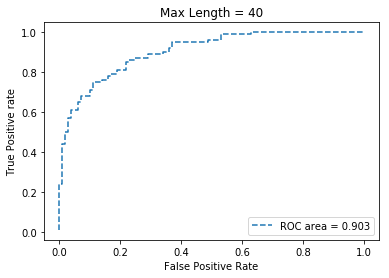

0.9029


In [148]:
y_true = [1]*100 + [0]*100
y_pred = [0]*200
for i in range(200):
    y_pred[i]= float(res_from_E[i]/res_from_F[i])
    
fpr, tpr, thresholds = metrics.roc_curve(y_true, np.log(y_pred))
plt.plot(fpr,tpr, label  = "ROC area = %0.3f" % auc(fpr, tpr), linestyle = '--')
plt.title("Max Length = 40")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.legend(loc = "best")
plt.show()
x= auc(fpr, tpr)
print(x)



**Discussion**

Both the models are performing quite well considering the amount of training done and the size of the dataset provided. The accuracy varies between 80% and 92%. An accuracy of > 80% is pretty good.
**Interesting note**
It can be observed in the generated sentences, while training that when diversity is low, the model repeats words, i.e, it takes less risks and the quality of words are better, less spelling mistakes. 
Increasing the diversity means the model takes more risk and generates more diverse words. This adversely affects the quality of generation since it makes more spelling mistake and the words dont make sense. However what is interesting is that, all predictions are made with diversity 1. Increasing or decreasing the diversity does not show any significant increase or decrease in accuracy. 

**Alternatives to Language Detection**

- Based on this[2] blog, tokenization of sequences of different languages using **ngrams** and then using a char analyzer to extract features on a char level and then using logistic regression to predict a class. 
    - N-Grams allow the structure of a language to be captured. Also, the dataset required is small and does not require a full dictionary of the language to be classified. 
- Using bag-of-words. 
    - Involves searching through a large dataset and basically performing template matching. Bag-of-words will fail if none of the words in the training set is included in the testing set. [3]
- Hidden Markov Models
    - Hidden Markov Models allow us to capture characteristics of sequential data. This can be translated to the fact that in case of a sequence of characters, each character has some dependency on the preceeding characters. Therefore the transition probability in moving from one state to another state maybe calculated [4]

**Ways in which the models can be improved are: **

- We could use GPUs to train the models. This would help it perform the training faster although it will not have any effect accuracy.
- We could use a larger dataset. This dataset is extremely small for a model to accurately predict languages. Using a larger corpus for training will help it to have better predictions and accuracies since it will be able to learn much more of how a language is written.
- We could increase the length of the pre-seen strings, thus helping it to learn over a bigger history. This would most probably improve the efficiency.
- We can train a bi-directional model that learns patterns of a language backwards as well as forward may be interesting to look at. (Performed in extra-credit)
- To get best results, our goal is to maximise the prediction of the correct word. To do that, if the model can be trained to learn from n preceeding charatcers as well as n succeeding characters, that would be an interesting experiment. This was performed but the model failed due to some errors explained below. 

**Extra Credit Work**

We performed a lot of trial and error testing and variations in the models to see how they differ in their performance. Below, we are describing some of the attempts that we made.

- Varying the number of iterations and epochs used.

As mentioned above, we had tried to train the model using 200 iterations with 10 epochs. This gave extremely good generated sentences but the predictions on the test sentences were not that great, giving an average accuracy of around 50-60%.
We also trained it with lesser iterations: 3 and more epochs: 20. This gave us varying results, where sometimes the accuracy would shoot up and sometimes it would fall low. But on an average, it remained constant at 70-80% with the English model performing better than the French.

- Varying the length of previous sequences.

We also changed the max length of the strings to be inputted to the models for prediction of the next character. 
We increased the length to 60 but the accuracies did not change as much, English = 70% and French = 82%. This made us think that an increase from 40 to 60 cannot be considered as substantial considering the size of the dataset that the model had bene trained with. Maybe if the dataset was much larger, then an increase would help generate better responses.
We also decreased the length to 10 and saw that the model performed visibly worse, giving an English accuracy of 70% and French accuracy of 73%. Thus, a decrease in the pre-seen string definitely reduces the chances of predicting the next character well.

- Using bidirectional LSTM.

We trained a bi-directional LSTM that reads a character sequence forward as well as backwards because we wanted to see if the LSTM could learn any character patterns backwards.
X_train = "I study Computer Scienc" and Y_train = "e". 
The simple bidirectional model defined above would read X_train forward and backwards. This is implemented by creating two sequential layers and merging them together and defining a single Activation for them.

The model is evaluated in a similar manner with the ROC curve plotted on a log scale and the results are slightly lower than the unidirectional one but still very good with the area of ROC as 0.895. 

- Using bi-directional Lookahead

The Bi-Directional model reads a sequence forward and backward. 

For example, Sentence = **'I study Computer Science at Georgia Tech".**

Normally we use LSTM's to generate text. However, here we want to use them to detect languages. To do that well, we need to maximise the probability of the correct letter. If the preceeding sentence is "I study Computer Scienc", then we want to maximise the probability of getting an e. So we thought of treating this problem like a 'fill-n-the-blank'. Usually in such cases, to predict what comes in the blank, we look at the succeeding text as well. 
So instead of using a bidirectional model to read the same text forward and backwards. we decided to try and train the bi directional model with two strings - 'I study Computer Scienc' and ' at Georgia Tech' with 'e' being the character to be predicted. Although we were able to implement a model that does the above, it was not successful. Because while training the model, we teach the model that 'e' comes **after** 'I study Computer Scienc'. But we were not able to teach the model that 'e' comes **before** ' at Georgia Tech' simultaneously. So the model basically learnt wrong and gave random results. Although we were not able to implement this successfully, we think the idea of using a lookahead sequence to generate correct words bears merit and should be further explored.

- Varying the architecture of LSTM

Our main goal is to study the performance of LSTM's as language detectors under various conditions. Therefore, we  trained two LSTM's for english and french strings using 256 nodes and implemented dropout to combat overfitting. By implementing 2 % dropout, the model basically ignores 2% of its hidden nodes randomly in each pass, so that the model generalizes well. 
This model was also tested on the **same** test strings as all other models. Based on the ROC curve, we see that it does not perform very well. This leads us to conclude that given the dataset and the sequence, 128 hidden nodes (in the original) is deep enough and adding extra nodes does not lead to any extra information being extracted or retained. Although this was not successful in improving the LSTM, we learnt that based on the data, increasing the depth of LSTM is only helpful after a certain point. 

- Performing Multiclass Classification

To gain an entirely new perspective, we performed multi-class classification. We were more curious about scoring the different language models, so instead of doing with too many languages, we chose to do it with 4 languages, since the text for each language is small. We chose English, French, Dutch and Portugese. For scoring them, we had a test set of 400 strings, with 100 strings from each language. For each string, we obtained probabilities from each model(probability was calculated the same way as original model). We chose the language corresponding to the highest probability. We then obtained a prediction for 400 strings and then we plotted a confusion matrix from it. 

More details for multiclass classification are included in the second ipython notebook. 

 

In [155]:
################################################   max length = 60   ############################################################

X_eng = open("eng.txt").read().lower()
print('X_eng length:', len(X_eng))

X_frn = open("frn.txt").read().lower()
print('X_frn length:', len(X_frn))

#### for english #####
numberE = int(0.80 * len(X_eng))
X_train_eng = X_eng[:numberE]
X_val_eng = X_eng[numberE:]
print ("English")
print ("training set contains ", len(X_train_eng), " characters")
print ("validation set contains ", len(X_val_eng), " characters")
print ("")
#### for french #####
numberF = int(0.80 * len(X_frn))
X_train_frn = X_frn[:numberF]
X_val_frn = X_frn[numberF:]
print ("French")
print ("training set contains ", len(X_train_frn), " characters")
print ("validation set contains ", len(X_val_frn), " characters")
print ("")

charsE = sorted(list(set(X_eng)))
charsF = sorted(list(set(X_frn)))
chars = set(charsE+charsF)
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

#### for english ####
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 60
step = 3
sentences_trainE = []
next_chars_trainE = []
for i in range(0, len(X_train_eng) - maxlen, step):
    sentences_trainE.append(X_train_eng[i: i + maxlen])
    next_chars_trainE.append(X_train_eng[i + maxlen])
print('nb sequences:', len(sentences_trainE))

maxlen = 60
step = 3
sentences_valE = []
next_chars_valE = []
for i in range(0, len(X_val_eng) - maxlen, step):
    sentences_valE.append(X_val_eng[i: i + maxlen])
    next_chars_valE.append(X_val_eng[i + maxlen])
print('nb sequences:', len(sentences_valE))

#### for french ####
maxlen = 60
step = 3
sentences_trainF = []
next_chars_trainF = []
for i in range(0, len(X_train_frn) - maxlen, step):
    sentences_trainF.append(X_train_frn[i: i + maxlen])
    next_chars_trainF.append(X_train_frn[i + maxlen])
print('nb sequences:', len(sentences_trainF))

maxlen = 60
step = 3
sentences_valF = []
next_chars_valF = []
for i in range(0, len(X_val_frn) - maxlen, step):
    sentences_valF.append(X_val_frn[i: i + maxlen])
    next_chars_valF.append(X_val_frn[i + maxlen])
print('nb sequences:', len(sentences_valF))

#### for english ####
print('Vectorization...')
X_train_eng_vec = np.zeros((len(sentences_trainE), maxlen, len(chars)), dtype=np.bool)
y_train_eng_vec = np.zeros((len(sentences_trainE), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_trainE):
    for t, char in enumerate(sentence):
        X_train_eng_vec[i, t, char_indices[char]] = 1
    y_train_eng_vec[i, char_indices[next_chars_trainE[i]]] = 1

X_val_eng_vec = np.zeros((len(sentences_valE), maxlen, len(chars)), dtype=np.bool)
y_val_eng_vec = np.zeros((len(sentences_valE), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_valE):
    for t, char in enumerate(sentence):
        X_val_eng_vec[i, t, char_indices[char]] = 1
    y_val_eng_vec[i, char_indices[next_chars_valE[i]]] = 1

#### for french ####
print('Vectorization...')
X_train_frn_vec = np.zeros((len(sentences_trainF), maxlen, len(chars)), dtype=np.bool)
y_train_frn_vec = np.zeros((len(sentences_trainF), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_trainF):
    for t, char in enumerate(sentence):
        X_train_frn_vec[i, t, char_indices[char]] = 1
    y_train_frn_vec[i, char_indices[next_chars_trainF[i]]] = 1

X_val_frn_vec = np.zeros((len(sentences_valF), maxlen, len(chars)), dtype=np.bool)
y_val_frn_vec = np.zeros((len(sentences_valF), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_valF):
    for t, char in enumerate(sentence):
        X_val_frn_vec[i, t, char_indices[char]] = 1
    y_val_frn_vec[i, char_indices[next_chars_valF[i]]] = 1

#### for english ####
print('Build model...')
modelE = Sequential()
modelE.add(LSTM(128, input_shape=(maxlen, len(chars))))
modelE.add(Dense(len(chars)))
modelE.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
modelE.compile(loss='categorical_crossentropy', optimizer=optimizer)

#### for french ####
print('Build model...')
modelF = Sequential()
modelF.add(LSTM(128, input_shape=(maxlen, len(chars))))
modelF.add(Dense(len(chars)))
modelF.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
modelF.compile(loss='categorical_crossentropy', optimizer=optimizer)

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def sample_for_prediction(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    return preds #exp_preds

X_val_tupleE = (X_val_eng_vec,y_val_eng_vec)
print (len(X_val_tupleE[0]))
X_val_tupleF = (X_val_frn_vec,y_val_frn_vec)
print (len(X_val_tupleF[0]))

#### for english ####
for iteration in range(0, 5):
    print()
    print('-' * 50)
    print('Iteration', iteration+1)
    modelE.fit(X_train_eng_vec, y_train_eng_vec, batch_size=128, epochs=5, validation_data=X_val_tupleE)

    start_index = random.randint(0, len(X_eng) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = X_eng[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(300):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = modelE.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

#### for french ####
for iteration in range(0, 5):
    print()
    print('-' * 50)
    print('Iteration', iteration+1)
    modelF.fit(X_train_frn_vec, y_train_frn_vec, batch_size=128, epochs=5, validation_data=X_val_tupleF)

    start_index = random.randint(0, len(X_frn) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = X_frn[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(300):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = modelF.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
    
def f(l, k, m, result=[]):
    if len(result) == m or len(l) == 0:
        return result
    else:
        if isinstance(l, str):
            l = [l]
        part_num = random.randint(0, len(l)-1)
        partition = l[part_num]
        start = random.randint(0, len(partition)-k)
        result.append(partition[start:start+k])
        l.remove(partition)
        l.extend([partition[:start], partition[start+k:]])
        return f([part for part in l if len(part) >= k], k, m, result)

def f1(l, k, m, result=[]):
    if len(result) == m or len(l) == 0:
        return result
    else:
        if isinstance(l, str):
            l = [l]
        part_num = random.randint(0, len(l)-1)
        partition = l[part_num]
        start = random.randint(0, len(partition)-k)
        result.append(partition[start:start+k])
        l.remove(partition)
        l.extend([partition[:start], partition[start+k:]])
        return f([part for part in l if len(part) >= k], k, m, result)

#ansE = f(X_val_eng[60:],5,100)
print ("first string: ",ansE[0])
prob_answersE = np.zeros(len(ansE),dtype=np.float)

#ansF = f1(X_val_frn[60:],5,100)
print ("first string: ",ansF[0])
prob_answersF = np.zeros(len(ansF),dtype=np.float)

### for english test strings on English Model

for instance in range(0,len(ansE)):
    START = X_val_eng.find(ansE[instance])
    count = 0
    testing_stringE = X_val_eng[START-62:START-1]
    val = 0
    for count in range(0,5):
        testing_stringE = X_val_eng[START-60+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringE):
            x[0, t, char_indices[char]] = 1.
        preds = modelE.predict(x, verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansE[instance][count])]))
    prob_answersE[instance] = np.exp(val)

### for french test strings on English Model

for instance in range(0,len(ansF)):
    START = X_val_frn.find(ansF[instance])
    count = 0
    testing_stringF = X_val_frn[START-62:START-1]
    val = 0
    for count in range(0,5):
        testing_stringF = X_val_frn[START-60+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringF):
            x[0, t, char_indices[char]] = 1.
        preds = modelE.predict(x, verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansF[instance][count])]))
    prob_answersF[instance] = np.exp(val)

res_from_E = prob_answersE.tolist() + prob_answersF.tolist()

zipped_for_Emodel = list(map(list, zip(prob_answersE, prob_answersF)))
countE=0
for i,j in zipped_for_Emodel:
    if(i>j):
        countE+=1
print (countE)

### for english test strings on French Model

for instance in range(0,len(ansE)):
    START = X_val_eng.find(ansE[instance])
    count = 0
    testing_stringE = X_val_eng[START-62:START-1]
    val = 0
    for count in range(0,5):
        testing_stringE = X_val_eng[START-60+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringE):
            x[0, t, char_indices[char]] = 1.
        preds = modelF.predict(x, verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansE[instance][count])]))
    prob_answersE[instance] = np.exp(val)

### for french test strings on French Model

for instance in range(0,len(ansF)):
    START = X_val_frn.find(ansF[instance])
    count = 0
    testing_stringF = X_val_frn[START-62:START-1]
    val = 0
    for count in range(0,5):
        testing_stringF = X_val_frn[START-60+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringF):
            x[0, t, char_indices[char]] = 1.
        preds = modelF.predict(x, verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansF[instance][count])]))
    prob_answersF[instance] = np.exp(val)

res_from_F = prob_answersE.tolist() + prob_answersF.tolist()
#print(len(res_from_F))

zipped_for_Fmodel = list(map(list, zip(prob_answersE, prob_answersF)))
countF=0
#print (zipped_for_Emodel)
for i,j in zipped_for_Fmodel:
    if(i<j):
        countF+=1
print (countF)


X_eng length: 10746
X_frn length: 12009
English
training set contains  8596  characters
validation set contains  2150  characters

French
training set contains  9607  characters
validation set contains  2402  characters

total chars: 44
nb sequences: 2846
nb sequences: 697
nb sequences: 3183
nb sequences: 781
Vectorization...
Vectorization...
Build model...
Build model...
697
781

--------------------------------------------------
Iteration 1
Train on 2846 samples, validate on 697 samples
Epoch 1/5
2846/2846 [==============================] - 29s - loss: 3.0855 - val_loss: 2.9284

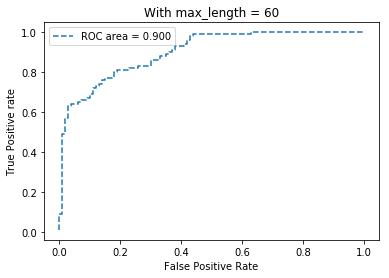

0.8999


In [157]:
y_true = [1]*100 + [0]*100
y_pred = [0]*200
for i in range(200):
    y_pred[i]= float(res_from_E[i]/res_from_F[i])
    
fpr, tpr, thresholds = metrics.roc_curve(y_true, np.log(y_pred))
#plt.plot(fpr, tpr, label = "ROC area = %0.3f" % auc(fpr, tpr))
plt.plot(fpr,tpr, label  = "ROC area = %0.3f" % auc(fpr, tpr), linestyle = '--')
plt.title("Max Length = 60")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.legend(loc = "best")
plt.title("With max_length = 60")
plt.show()
x= auc(fpr, tpr)
print(x)

In [153]:
################################################   max length = 10   ############################################################

X_eng = open("eng.txt").read().lower()
print('X_eng length:', len(X_eng))

X_frn = open("frn.txt").read().lower()
print('X_frn length:', len(X_frn))

#### for english #####
numberE = int(0.80 * len(X_eng))
X_train_eng = X_eng[:numberE]
X_val_eng = X_eng[numberE:]
print ("English")
print ("training set contains ", len(X_train_eng), " characters")
print ("validation set contains ", len(X_val_eng), " characters")
print ("")
#### for french #####
numberF = int(0.80 * len(X_frn))
X_train_frn = X_frn[:numberF]
X_val_frn = X_frn[numberF:]
print ("French")
print ("training set contains ", len(X_train_frn), " characters")
print ("validation set contains ", len(X_val_frn), " characters")
print ("")

charsE = sorted(list(set(X_eng)))
charsF = sorted(list(set(X_frn)))
chars = set(charsE+charsF)
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

#### for english ####
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 10
step = 3
sentences_trainE = []
next_chars_trainE = []
for i in range(0, len(X_train_eng) - maxlen, step):
    sentences_trainE.append(X_train_eng[i: i + maxlen])
    next_chars_trainE.append(X_train_eng[i + maxlen])
print('nb sequences:', len(sentences_trainE))

maxlen = 10
step = 3
sentences_valE = []
next_chars_valE = []
for i in range(0, len(X_val_eng) - maxlen, step):
    sentences_valE.append(X_val_eng[i: i + maxlen])
    next_chars_valE.append(X_val_eng[i + maxlen])
print('nb sequences:', len(sentences_valE))

#### for french ####
maxlen = 10
step = 3
sentences_trainF = []
next_chars_trainF = []
for i in range(0, len(X_train_frn) - maxlen, step):
    sentences_trainF.append(X_train_frn[i: i + maxlen])
    next_chars_trainF.append(X_train_frn[i + maxlen])
print('nb sequences:', len(sentences_trainF))

maxlen = 10
step = 3
sentences_valF = []
next_chars_valF = []
for i in range(0, len(X_val_frn) - maxlen, step):
    sentences_valF.append(X_val_frn[i: i + maxlen])
    next_chars_valF.append(X_val_frn[i + maxlen])
print('nb sequences:', len(sentences_valF))

#### for english ####
print('Vectorization...')
X_train_eng_vec = np.zeros((len(sentences_trainE), maxlen, len(chars)), dtype=np.bool)
y_train_eng_vec = np.zeros((len(sentences_trainE), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_trainE):
    for t, char in enumerate(sentence):
        X_train_eng_vec[i, t, char_indices[char]] = 1
    y_train_eng_vec[i, char_indices[next_chars_trainE[i]]] = 1

X_val_eng_vec = np.zeros((len(sentences_valE), maxlen, len(chars)), dtype=np.bool)
y_val_eng_vec = np.zeros((len(sentences_valE), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_valE):
    for t, char in enumerate(sentence):
        X_val_eng_vec[i, t, char_indices[char]] = 1
    y_val_eng_vec[i, char_indices[next_chars_valE[i]]] = 1

#### for french ####
print('Vectorization...')
X_train_frn_vec = np.zeros((len(sentences_trainF), maxlen, len(chars)), dtype=np.bool)
y_train_frn_vec = np.zeros((len(sentences_trainF), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_trainF):
    for t, char in enumerate(sentence):
        X_train_frn_vec[i, t, char_indices[char]] = 1
    y_train_frn_vec[i, char_indices[next_chars_trainF[i]]] = 1

X_val_frn_vec = np.zeros((len(sentences_valF), maxlen, len(chars)), dtype=np.bool)
y_val_frn_vec = np.zeros((len(sentences_valF), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_valF):
    for t, char in enumerate(sentence):
        X_val_frn_vec[i, t, char_indices[char]] = 1
    y_val_frn_vec[i, char_indices[next_chars_valF[i]]] = 1

#### for english ####
print('Build model...')
modelE = Sequential()
modelE.add(LSTM(128, input_shape=(maxlen, len(chars))))
modelE.add(Dense(len(chars)))
modelE.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
modelE.compile(loss='categorical_crossentropy', optimizer=optimizer)

#### for french ####
print('Build model...')
modelF = Sequential()
modelF.add(LSTM(128, input_shape=(maxlen, len(chars))))
modelF.add(Dense(len(chars)))
modelF.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
modelF.compile(loss='categorical_crossentropy', optimizer=optimizer)

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def sample_for_prediction(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    return preds #exp_preds

X_val_tupleE = (X_val_eng_vec,y_val_eng_vec)
print (len(X_val_tupleE[0]))
X_val_tupleF = (X_val_frn_vec,y_val_frn_vec)
print (len(X_val_tupleF[0]))

#### for english ####
for iteration in range(0, 5):
    print()
    print('-' * 50)
    print('Iteration', iteration+1)
    modelE.fit(X_train_eng_vec, y_train_eng_vec, batch_size=128, epochs=5, validation_data=X_val_tupleE)

    start_index = random.randint(0, len(X_eng) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = X_eng[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(300):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = modelE.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

#### for french ####
for iteration in range(0, 5):
    print()
    print('-' * 50)
    print('Iteration', iteration+1)
    modelF.fit(X_train_frn_vec, y_train_frn_vec, batch_size=128, epochs=5, validation_data=X_val_tupleF)

    start_index = random.randint(0, len(X_frn) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = X_frn[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(300):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = modelF.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
    
def f(l, k, m, result=[]):
    if len(result) == m or len(l) == 0:
        return result
    else:
        if isinstance(l, str):
            l = [l]
        part_num = random.randint(0, len(l)-1)
        partition = l[part_num]
        start = random.randint(0, len(partition)-k)
        result.append(partition[start:start+k])
        l.remove(partition)
        l.extend([partition[:start], partition[start+k:]])
        return f([part for part in l if len(part) >= k], k, m, result)

def f1(l, k, m, result=[]):
    if len(result) == m or len(l) == 0:
        return result
    else:
        if isinstance(l, str):
            l = [l]
        part_num = random.randint(0, len(l)-1)
        partition = l[part_num]
        start = random.randint(0, len(partition)-k)
        result.append(partition[start:start+k])
        l.remove(partition)
        l.extend([partition[:start], partition[start+k:]])
        return f([part for part in l if len(part) >= k], k, m, result)

#ansE = f(X_val_eng[10:],5,100)
print ("first string: ",ansE[0])
prob_answersE = np.zeros(len(ansE),dtype=np.float)

#ansF = f1(X_val_frn[10:],5,100)
print ("first string: ",ansF[0])
prob_answersF = np.zeros(len(ansF),dtype=np.float)

### for english test strings on English Model

for instance in range(0,len(ansE)):
    START = X_val_eng.find(ansE[instance])
    count = 0
    testing_stringE = X_val_eng[START-12:START-1]
    val = 0
    for count in range(0,5):
        testing_stringE = X_val_eng[START-10+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringE):
            x[0, t, char_indices[char]] = 1.
        preds = modelE.predict(x, verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansE[instance][count])]))
    prob_answersE[instance] = np.exp(val)

### for french test strings on English Model

for instance in range(0,len(ansF)):
    START = X_val_frn.find(ansF[instance])
    count = 0
    testing_stringF = X_val_frn[START-12:START-1]
    val = 0
    for count in range(0,5):
        testing_stringF = X_val_frn[START-10+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringF):
            x[0, t, char_indices[char]] = 1.
        preds = modelE.predict(x, verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansF[instance][count])]))
    prob_answersF[instance] = np.exp(val)

res_from_E = prob_answersE.tolist() + prob_answersF.tolist()

zipped_for_Emodel = list(map(list, zip(prob_answersE, prob_answersF)))
countE=0
for i,j in zipped_for_Emodel:
    if(i>j):
        countE+=1
print (countE)

### for english test strings on French Model

for instance in range(0,len(ansE)):
    START = X_val_eng.find(ansE[instance])
    count = 0
    testing_stringE = X_val_eng[START-12:START-1]
    val = 0
    for count in range(0,5):
        testing_stringE = X_val_eng[START-10+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringE):
            x[0, t, char_indices[char]] = 1.
        preds = modelF.predict(x, verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansE[instance][count])]))
    prob_answersE[instance] = np.exp(val)

### for french test strings on French Model

for instance in range(0,len(ansF)):
    START = X_val_frn.find(ansF[instance])
    count = 0
    testing_stringF = X_val_frn[START-12:START-1]
    val = 0
    for count in range(0,5):
        testing_stringF = X_val_frn[START-10+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringF):
            x[0, t, char_indices[char]] = 1.
        preds = modelF.predict(x, verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansF[instance][count])]))
    prob_answersF[instance] = np.exp(val)

res_from_F = prob_answersE.tolist() + prob_answersF.tolist()
#print(len(res_from_F))

zipped_for_Fmodel = list(map(list, zip(prob_answersE, prob_answersF)))
countF=0
#print (zipped_for_Emodel)
for i,j in zipped_for_Fmodel:
    if(i<j):
        countF+=1
print (countF)


X_eng length: 10746
X_frn length: 12009
English
training set contains  8596  characters
validation set contains  2150  characters

French
training set contains  9607  characters
validation set contains  2402  characters

total chars: 44
nb sequences: 2862
nb sequences: 714
nb sequences: 3199
nb sequences: 798
Vectorization...
Vectorization...
Build model...
Build model...
714
798

--------------------------------------------------
Iteration 1
Train on 2862 samples, validate on 714 samples
Epoch 1/5
2862/2862 [==============================] - 8s - loss: 3.1465 - val_loss: 2.9786

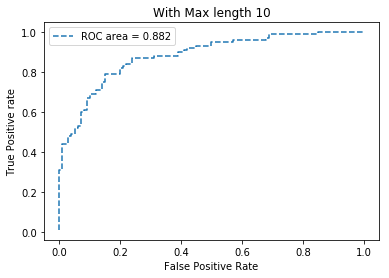

0.8819


In [154]:
y_true = [1]*100 + [0]*100
y_pred = [0]*200
for i in range(200):
    y_pred[i]= float(res_from_E[i]/res_from_F[i])
    
fpr, tpr, thresholds = metrics.roc_curve(y_true, np.log(y_pred))
#plt.plot(fpr, tpr, label = "ROC area = %0.3f" % auc(fpr, tpr))
plt.plot(fpr,tpr, label  = "ROC area = %0.3f" % auc(fpr, tpr), linestyle = '--')
plt.title("Max Length = 10")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.legend(loc = "best")
plt.title("With Max length 10")
plt.show()
x= auc(fpr, tpr)
print(x)

**BI DIRECTIONAL MODEL**

In [162]:
################################################   bidirectional model   #######################################################

maxlen = 40
step = 3
sentences_trainE = []
next_chars_trainE = []
for i in range(0, len(X_train_eng) - maxlen, step):
    sentences_trainE.append(X_train_eng[i: i + maxlen])
    next_chars_trainE.append(X_train_eng[i + maxlen])
print('nb sequences:', len(sentences_trainE))

maxlen = 40
step = 3
sentences_valE = []
next_chars_valE = []
for i in range(0, len(X_val_eng) - maxlen, step):
    sentences_valE.append(X_val_eng[i: i + maxlen])
    next_chars_valE.append(X_val_eng[i + maxlen])
print('nb sequences:', len(sentences_valE))

#### for french ####
maxlen = 40
step = 3
sentences_trainF = []
next_chars_trainF = []
for i in range(0, len(X_train_frn) - maxlen, step):
    sentences_trainF.append(X_train_frn[i: i + maxlen])
    next_chars_trainF.append(X_train_frn[i + maxlen])
print('nb sequences:', len(sentences_trainF))

maxlen = 40
step = 3
sentences_valF = []
next_chars_valF = []
for i in range(0, len(X_val_frn) - maxlen, step):
    sentences_valF.append(X_val_frn[i: i + maxlen])
    next_chars_valF.append(X_val_frn[i + maxlen])
print('nb sequences:', len(sentences_valF))

nb sequences: 2852
nb sequences: 704
nb sequences: 3189
nb sequences: 788


In [159]:
#### for english ####
print('Vectorization...')
X_train_eng_vec = np.zeros((len(sentences_trainE), maxlen, len(chars)), dtype=np.bool)
y_train_eng_vec = np.zeros((len(sentences_trainE), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_trainE):
    for t, char in enumerate(sentence):
        X_train_eng_vec[i, t, char_indices[char]] = 1
    y_train_eng_vec[i, char_indices[next_chars_trainE[i]]] = 1

X_val_eng_vec = np.zeros((len(sentences_valE), maxlen, len(chars)), dtype=np.bool)
y_val_eng_vec = np.zeros((len(sentences_valE), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_valE):
    for t, char in enumerate(sentence):
        X_val_eng_vec[i, t, char_indices[char]] = 1
    y_val_eng_vec[i, char_indices[next_chars_valE[i]]] = 1

#### for french ####
print('Vectorization...')
X_train_frn_vec = np.zeros((len(sentences_trainF), maxlen, len(chars)), dtype=np.bool)
y_train_frn_vec = np.zeros((len(sentences_trainF), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_trainF):
    for t, char in enumerate(sentence):
        X_train_frn_vec[i, t, char_indices[char]] = 1
    y_train_frn_vec[i, char_indices[next_chars_trainF[i]]] = 1

X_val_frn_vec = np.zeros((len(sentences_valF), maxlen, len(chars)), dtype=np.bool)
y_val_frn_vec = np.zeros((len(sentences_valF), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_valF):
    for t, char in enumerate(sentence):
        X_val_frn_vec[i, t, char_indices[char]] = 1
    y_val_frn_vec[i, char_indices[next_chars_valF[i]]] = 1


Vectorization...
Vectorization...


In [82]:
###### BI-DIRECTIONAL MODEL ########
maxlen = 40
hidden_units = 128
input_shape = (maxlen, len(chars))
left = Sequential()
left.add(LSTM(output_dim=hidden_units, init='uniform', inner_init='uniform',
               forget_bias_init='one', return_sequences=False, activation='tanh',
               inner_activation='sigmoid', input_shape=input_shape))
right = Sequential()
right.add(LSTM(output_dim=hidden_units, init='uniform', inner_init='uniform',
               forget_bias_init='one', return_sequences=False, activation='tanh',
               inner_activation='sigmoid', input_shape=input_shape, go_backwards=True))

print(left.summary())
modelBi_E = Sequential()
modelBi_E.add(Merge([left, right], mode='sum'))

modelBi_E.add(Dense(len(chars)))
modelBi_E.add(Activation('softmax'))

sgd = SGD(lr=0.1, decay=1e-5, momentum=0.9, nesterov=True)
modelBi_E.compile(loss='categorical_crossentropy', optimizer=sgd)
print(modelBi_E.summary())




left = Sequential()
left.add(LSTM(output_dim=hidden_units, init='uniform', inner_init='uniform',
               forget_bias_init='one', return_sequences=False, activation='tanh',
               inner_activation='sigmoid', input_shape=input_shape))
right = Sequential()
right.add(LSTM(output_dim=hidden_units, init='uniform', inner_init='uniform',
               forget_bias_init='one', return_sequences=False, activation='tanh',
               inner_activation='sigmoid', input_shape=input_shape, go_backwards=True))

print(left.summary())
modelBi_F = Sequential()
modelBi_F.add(Merge([left, right], mode='sum'))

modelBi_F.add(Dense(len(chars)))
modelBi_F.add(Activation('softmax'))

sgd = SGD(lr=0.1, decay=1e-5, momentum=0.9, nesterov=True)
modelBi_F.compile(loss='categorical_crossentropy', optimizer=sgd)
print(modelBi_F.summary())
print('Done')

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(recurrent_activation="sigmoid", return_sequences=False, units=128, input_shape=(40, 44), recurrent_initializer="uniform", kernel_initializer="uniform", activation="tanh", unit_forget_bias=True)`
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(recurrent_activation="sigmoid", return_sequences=False, units=128, input_shape=(40, 44), kernel_initializer="uniform", go_backwards=True, recurrent_initializer="uniform", activation="tanh", unit_forget_bias=True)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 128)               88576     
Total params: 88,576
Trainable params: 88,576
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_7 (Merge)              (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 44)                5676      
_________________________________________________________________
activation_25 (Activation)   (None, 44)                0         
Total params: 182,828
Trainable params: 182,828
Non-trainable params: 0
_________________________________________________________________
None


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:16: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:31: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(recurrent_activation="sigmoid", return_sequences=False, units=128, input_shape=(40, 44), recurrent_initializer="uniform", kernel_initializer="uniform", activation="tanh", unit_forget_bias=True)`
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:35: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(recurrent_activation="sigmoid", return_sequences=False, units=128, input_shape=(40, 44), kernel_initializer="uniform", go_backwards=True, recurrent_initializer="uniform", activation="tanh", unit_forget_bias=Tr

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 128)               88576     
Total params: 88,576
Trainable params: 88,576
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_8 (Merge)              (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 44)                5676      
_________________________________________________________________
activation_26 (Activation)   (None, 44)                0         
Total params: 182,828
Trainable params: 182,828
Non-trainable params: 0
_________________________________________________________________
None
Done


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:39: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [83]:
for iteration in range(0, 5):
    print()
    print('-' * 50)
    print('Iteration', iteration+1)
    modelBi_E.fit([X_train_eng_vec, X_train_eng_vec], y_train_eng_vec, batch_size=128, nb_epoch=10, validation_data=([X_val_eng_vec, X_val_eng_vec], y_val_eng_vec), verbose=1)

    start_index = random.randint(0, len(X_eng) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = X_eng[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(300):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = modelBi_E.predict([x,x],verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

#### for french ####
for iteration in range(0, 5):
    print()
    print('-' * 50)
    print('Iteration', iteration+1)
    modelBi_F.fit([X_train_frn_vec, X_train_frn_vec], y_train_frn_vec, batch_size=128, nb_epoch=5, validation_data=([X_val_frn_vec, X_val_frn_vec], y_val_frn_vec), verbose=1)

    start_index = random.randint(0, len(X_frn) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = X_frn[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(300):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = modelBi_F.predict([x,x], verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


--------------------------------------------------
Iteration 1


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 2852 samples, validate on 704 samples
Epoch 1/10
2852/2852 [==============================] - 17s - loss: 3.2254 - val_loss: 2.9949

In [118]:
## For english test strings on Bi_English Model
maxlen = 40
for instance in range(0,len(ansE)):
    START = X_val_eng.find(ansE[instance])
    count = 0
    testing_stringE = X_val_eng[START-42:START-1]
    val = 0
    for count in range(0,5):
        testing_stringE = X_val_eng[START-40+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringE):
            x[0, t, char_indices[char]] = 1.
        preds = modelBi_E.predict([x,x], verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansE[instance][count])]))
    prob_answersE[instance] = np.exp(val)
    
### for french test strings on English Model


for instance in range(0,len(ansF)):
    START = X_val_frn.find(ansF[instance])
    count = 0
    testing_stringF = X_val_frn[START-42:START-1]
    val = 0
    for count in range(0,5):
        testing_stringF = X_val_frn[START-40+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringF):
            x[0, t, char_indices[char]] = 1.
        preds = modelBi_E.predict([x,x],verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansF[instance][count])]))
    prob_answersF[instance] = np.exp(val)

res_from_E = prob_answersE.tolist() + prob_answersF.tolist()

zipped_for_Emodel = list(map(list, zip(prob_answersE, prob_answersF)))
countE=0
for i,j in zipped_for_Emodel:
    if(i>j):
        countE+=1
print (countE)

75


In [119]:
#Test strings on french model
for instance in range(0,len(ansE)):
    START = X_val_eng.find(ansE[instance])
    count = 0
    testing_stringE = X_val_eng[START-42:START-1]
    val = 0
    for count in range(0,5):
        testing_stringE = X_val_eng[START-40+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringE):
            x[0, t, char_indices[char]] = 1.
        preds = modelBi_F.predict([x,x], verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansE[instance][count])]))
    prob_answersE[instance] = np.exp(val)

### for french test strings on French Model
for instance in range(0,len(ansF)):
    START = X_val_frn.find(ansF[instance])
    count = 0
    testing_stringF = X_val_frn[START-42:START-1]
    val = 0
    for count in range(0,5):
        testing_stringF = X_val_frn[START-40+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringF):
            x[0, t, char_indices[char]] = 1.
        preds = modelBi_F.predict([x,x], verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansF[instance][count])]))
    prob_answersF[instance] = np.exp(val)

res_from_F = prob_answersE.tolist() + prob_answersF.tolist()
print(len(res_from_F))

zipped_for_Fmodel = list(map(list, zip(prob_answersE, prob_answersF)))
countF=0
for i,j in zipped_for_Fmodel:
    if(i<j):
        countF+=1
print (countF)

200
76


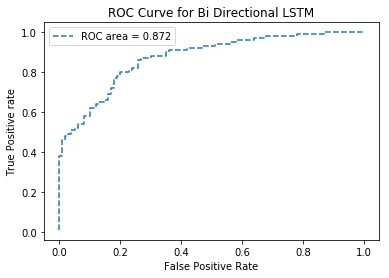

0.8723


In [121]:
y_true = [1]*100 + [0]*100
y_pred = [0]*200
for i in range(200):
    y_pred[i]= float(res_from_E[i]/res_from_F[i])
    
fpr, tpr, thresholds = metrics.roc_curve(y_true, np.log(y_pred))
#plt.plot(fpr, tpr, label = "ROC area = %0.3f" % auc(fpr, tpr))
plt.plot(fpr,tpr, label  = "ROC area = %0.3f" % auc(fpr, tpr), linestyle = '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.legend(loc = "best")
plt.title("ROC Curve for Bi Directional LSTM")
plt.show()
x= auc(fpr, tpr)
print(x)

**MODEL WITH GREATER HIDDEN NODES AND DROPOUT**

In [171]:
#Model with dropout to reduce overfitting and greater hidden nodes

maxlen = 40

print('Build model...')
model_E = Sequential()
model_E.add(LSTM(256, dropout=0.2,input_shape=(maxlen, len(chars))))
model_E.add(Dense(len(chars)))
model_E.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
model_E.compile(loss='categorical_crossentropy', optimizer=optimizer)

print('Build model...')
model_F = Sequential()
model_F.add(LSTM(256,dropout=0.2, input_shape=(maxlen, len(chars))))
model_F.add(Dense(len(chars)))
model_F.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
model_F.compile(loss='categorical_crossentropy', optimizer=optimizer)

for iteration in range(0, 5):
    print()
    print('-' * 50)
    print('Iteration', iteration+1)
    model_E.fit(X_train_eng_vec, y_train_eng_vec, batch_size=128, epochs=5, validation_data=X_val_tupleE)

    start_index = random.randint(0, len(X_eng) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = X_eng[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(300):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model_E.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

#### for french ####
for iteration in range(0, 5):
    print()
    print('-' * 50)
    print('Iteration', iteration+1)
    model_F.fit(X_train_frn_vec, y_train_frn_vec, batch_size=128, epochs=5, validation_data=X_val_tupleF)

    start_index = random.randint(0, len(X_frn) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = X_frn[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(300):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model_F.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


Build model...
Build model...

--------------------------------------------------
Iteration 1
Train on 2852 samples, validate on 704 samples
Epoch 1/5
2852/2852 [==============================] - 24s - loss: 3.5117 - val_loss: 3.5265

In [172]:
for instance in range(0,len(ansE)):
    START = X_val_eng.find(ansE[instance])
    count = 0
    testing_stringE = X_val_eng[START-42:START-1]
    val = 0
    for count in range(0,5):
        testing_stringE = X_val_eng[START-40+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringE):
            x[0, t, char_indices[char]] = 1.
        preds = model_E.predict(x, verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansE[instance][count])]))
    prob_answersE[instance] = np.exp(val)

### for french test strings on English Model

for instance in range(0,len(ansF)):
    START = X_val_frn.find(ansF[instance])
    count = 0
    testing_stringF = X_val_frn[START-42:START-1]
    val = 0
    for count in range(0,5):
        testing_stringF = X_val_frn[START-40+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringF):
            x[0, t, char_indices[char]] = 1.
        preds = model_E.predict(x, verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansF[instance][count])]))
    prob_answersF[instance] = np.exp(val)

res_from_E = prob_answersE.tolist() + prob_answersF.tolist()

zipped_for_Emodel = list(map(list, zip(prob_answersE, prob_answersF)))
countE=0
for i,j in zipped_for_Emodel:
    if(i>j):
        countE+=1
print (countE)

for instance in range(0,len(ansE)):
    START = X_val_eng.find(ansE[instance])
    count = 0
    testing_stringE = X_val_eng[START-42:START-1]
    val = 0
    for count in range(0,5):
        testing_stringE = X_val_eng[START-40+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringE):
            x[0, t, char_indices[char]] = 1.
        preds = model_F.predict(x, verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansE[instance][count])]))
    prob_answersE[instance] = np.exp(val)

### for french test strings on French Model

for instance in range(0,len(ansF)):
    START = X_val_frn.find(ansF[instance])
    count = 0
    testing_stringF = X_val_frn[START-42:START-1]
    val = 0
    for count in range(0,5):
        testing_stringF = X_val_frn[START-40+count:START+count]
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(testing_stringF):
            x[0, t, char_indices[char]] = 1.
        preds = model_F.predict(x, verbose=0)[0]
        preds_for_test = sample_for_prediction(preds)
        val += ((preds_for_test[char_indices.get(ansF[instance][count])]))
    prob_answersF[instance] = np.exp(val)

res_from_F = prob_answersE.tolist() + prob_answersF.tolist()
#print(len(res_from_F))

zipped_for_Fmodel = list(map(list, zip(prob_answersE, prob_answersF)))
countF=0
#print (zipped_for_Emodel)
for i,j in zipped_for_Fmodel:
    if(i<j):
        countF+=1
print (countF)

81
44


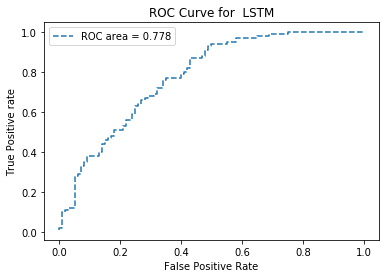

0.7777


In [96]:
y_true = [1]*100 + [0]*100
y_pred = [0]*200
for i in range(200):
    y_pred[i]= float(res_from_E[i]/res_from_F[i])
    
fpr, tpr, thresholds = metrics.roc_curve(y_true, np.log(y_pred))
#plt.plot(fpr, tpr, label = "ROC area = %0.3f" % auc(fpr, tpr))
plt.plot(fpr,tpr, label  = "ROC area = %0.3f" % auc(fpr, tpr), linestyle = '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.legend(loc = "best")
plt.title("ROC Curve for  LSTM")
plt.show()
x= auc(fpr, tpr)
print(x)

**References:**

[1] https://en.wikipedia.org/wiki/Long_short-term_memory

[2]https://bugra.github.io/work/notes/2014-12-26/language-detector-via-scikit-learn/

[3]https://stats.stackexchange.com/questions/144900/why-is-n-gram-used-in-text-language-identification-instead-of-words

[4] https://www.doc.ic.ac.uk/~nd/surprise_96/journal/vol2/ur1/article2.html

[5] https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py